# Импортируем библиотеки


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
import pandas as pd
import xgboost as xgb
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re


from collections import Counter



%matplotlib inline

# Скачиваем данные

In [ ]:
!wget https://onti-2019.s3-eu-central-1.amazonaws.com/public/data_v1.zip

In [ ]:
!unzip data_v1.zip

# Считываем данные

In [ ]:
transactions_train=pd.read_csv('data/transactions_train.csv')
transactions_test=pd.read_csv('data/transactions_test.csv')
train_target=pd.read_csv('data/train_target.csv')
# group = pd.read_csv('data/small_group_description.csv')

In [ ]:
transactions = transactions_train.append(transactions_test)

In [ ]:
transactions.shape

(44117905, 4)

# Анализ данных

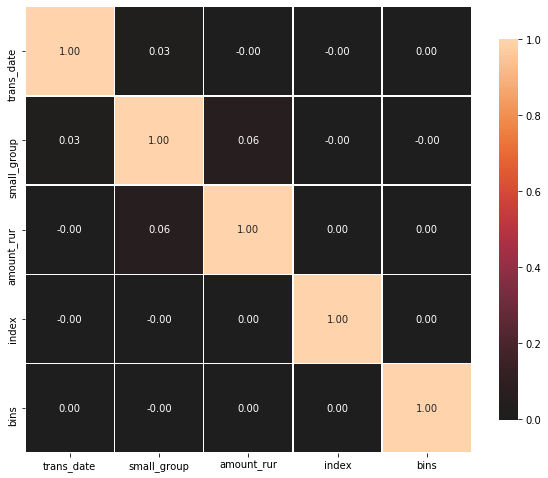

In [ ]:
def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show();
    
correlation_heatmap(transactions_train.merge(train_target.reset_index(),on='client_id').drop(['client_id'],axis=1))

In [ ]:
import pandas as pd
dta = pd.read_csv('Transactions.csv')

# Создание фичей

In [ ]:
temp = [2,5,6,7,8,10,13,14,18,19,21,23,24,28,29,32,39,40,42,43,44,46,52,53,54,58,59,60,61,64,65,66,72,75,76,77,78,80,82,83,87,91,92,94,102,103,107,109,112,114,115,120,123,141,176]

In [ ]:
temp = transactions.small_group.isin(temp)
transactions['+18'] = temp

Логарифм от трат

In [ ]:
transactions['amount_rur_log'] = np.log(transactions_train['amount_rur'])

In [ ]:
transactions['amount_rur_log210'] = np.log(np.log(transactions['amount_rur']+10))

Начало сбора данных предположительно составляет 1 января 2017 года. Нет високосного года, нашли праздники (1 января меньше всего трат, 8 марта покупают много цветов), а по пятницам покупают много алкоголя.

In [ ]:
transactions['trans_date_form'] = pd.to_datetime(transactions['trans_date'], unit='D', origin=pd.Timestamp('2017-01-01'))

In [ ]:

transactions[transactions['trans_date_form'] == '2017-02-20']

,client_id,trans_date,small_group,amount_rur,+18,amount_rur_log,amount_rur_log210,trans_date_form
49,33172,50,3,21.564,False,3.071025,1.238959,2017-02-20
780,3694,50,33,113.941,False,4.735681,1.572734,2017-02-20
3030,26959,50,4,31.268,False,3.442595,1.313747,2017-02-20
5520,44477,50,1,31.585,False,3.452682,1.315802,2017-02-20
6236,20434,50,24,94.794,True,4.551706,1.537296,2017-02-20
...,...,...,...,...,...,...,...,...
17645218,47801,50,11,17.997,False,3.515537,1.203602,2017-02-20
17651983,43569,50,1,7.419,False,4.202915,1.049969,2017-02-20
17664894,11441,50,15,6.263,False,4.383800,1.025645,2017-02-20
17664895,11441,50,55,8.243,False,3.545500,1.066014,2017-02-20


In [ ]:
temp = transactions['trans_date_form'].map(lambda x: x.month)
transactions['month'] = temp

In [ ]:
transactions['trans_date_week'] = transactions['trans_date'].apply(lambda x: x % 7).apply(lambda x: 7 if (x==0) else x)

In [ ]:
transactions['is_weekend'] = (transactions['trans_date_week'] == 6) | (transactions['trans_date_week'] == 7)

Пики трат именно в эти дни

In [ ]:
transactions['is_fs'] = (transactions['trans_date_week'] == 5) | (transactions['trans_date_week'] == 6)

Группируем по неделям

In [ ]:
temp = transactions.groupby(['client_id', pd.Grouper(key='trans_date_form', freq='W-MON')])['amount_rur'].sum().reset_index().sort_values('trans_date_form')

In [ ]:
temp = temp.groupby(['client_id']).agg({'amount_rur':'mean'})

In [ ]:
transactions = transactions.merge(temp.reset_index(), on='client_id')

In [ ]:
transactions.head()

,client_id,trans_date,small_group,amount_rur_x,+18,amount_rur_log,amount_rur_log210,trans_date_form,month,trans_date_week,is_weekend,is_fs,amount_rur_y
0,33172,6,4,71.463,False,4.269180,1.481638,2017-01-07,1,6,True,True,476.229041
1,33172,6,35,45.017,False,3.807040,1.388203,2017-01-07,1,6,True,True,476.229041
2,33172,8,11,13.887,False,2.630953,1.154783,2017-01-09,1,1,False,False,476.229041
3,33172,9,11,15.983,False,2.771526,1.180942,2017-01-10,1,2,False,False,476.229041
4,33172,10,11,21.341,False,3.060630,1.236903,2017-01-11,1,3,False,False,476.229041


In [ ]:
transactions = transactions.rename({'amount_rur_x':'amount_rur'},axis=1)

Стандартные характеристики

In [ ]:
main_fea=transactions.groupby('client_id')['amount_rur'].agg(['mean'])

In [ ]:
main_fea.columns =  ['fea1 ' + str(i) for i in range(len(main_fea.columns))]

In [ ]:
main_fea=transactions.groupby('client_id')['small_group'].agg(['mean'])

In [ ]:
main_fea.columns =  ['fea1n ' + str(i) for i in range(len(main_fea.columns))]

Стандартные характеристики с разделением на группы

In [ ]:
temp = transactions.groupby(['client_id','small_group'])['amount_rur'].agg(['mean'])

In [ ]:
temp2 = pd.DataFrame()
for col in temp.columns:
  temp2 = pd.concat([temp2, temp.reset_index().pivot(index='client_id', columns='small_group', values=col)], axis=1)

temp2 = temp2.fillna(0)

In [ ]:
temp2.columns = ['fea2 ' + str(i) for i in range(len(temp2.columns))]

In [ ]:
main_fea = pd.merge(main_fea, temp2, on='client_id')

Фичи по месяцам и неделям

In [ ]:
transactions['trans_date_week'] = transactions['trans_date_week'].astype(str).astype('object')
transactions.month = transactions.month.astype(str).astype('object')

In [ ]:
temp = transactions.groupby(['client_id','trans_date_week'])['amount_rur'].agg(['mean'])

In [ ]:
temp2 = pd.DataFrame()
for col in temp.columns:
  temp2 = pd.concat([temp2, temp.reset_index().pivot(index='client_id', columns='trans_date_week', values=col)], axis=1)

temp2 = temp2.fillna(0)

In [ ]:
temp2.columns =  ['fea3 ' + str(i) for i in range(len(temp2.columns))]

In [ ]:
main_fea = pd.merge(main_fea, temp2, on='client_id')

Фичи по выходным


In [ ]:
temp = transactions[transactions['is_weekend'] == 1].groupby(['client_id','small_group'])['amount_rur'].agg(['mean'])

In [ ]:
temp2 = pd.DataFrame()
for col in temp.columns:
  temp2 = pd.concat([temp2, temp.reset_index().pivot(index='client_id', columns='small_group', values=col)], axis=1)
temp2 = temp2.fillna(0)

In [ ]:
temp2.columns = ['fea4 ' + str(i) for i in range(len(temp2.columns))]

In [ ]:
main_fea = pd.merge(main_fea, temp2, on='client_id')

Фичи по будням

In [ ]:
temp = transactions[transactions['is_weekend'] != 1].groupby(['client_id','small_group'])['amount_rur'].agg(['mean'])

In [ ]:
temp2 = pd.DataFrame()
for col in temp.columns:
  temp2 = pd.concat([temp2, temp.reset_index().pivot(index='client_id', columns='small_group', values=col)], axis=1)

temp2 = temp2.fillna(0)

In [ ]:
temp2.columns = ['fea5 ' + str(i) for i in range(len(temp2.columns))]

In [ ]:
main_fea = pd.merge(main_fea, temp2, on='client_id')

Фича по месяцам

In [ ]:
temp = transactions.groupby(['client_id','month'])['amount_rur'].agg(['mean'])

In [ ]:
temp2 = pd.DataFrame()
for col in temp.columns:
  temp2 = pd.concat([temp2, temp.reset_index().pivot(index='client_id', columns='month', values=col)], axis=1)

temp2 = temp2.fillna(0)

In [ ]:
main_fea = pd.merge(main_fea, temp2, on='client_id')

Фича по пятницам-субботам #

In [ ]:
temp = transactions[transactions['is_fs'] == 1].groupby(['client_id','small_group'])['amount_rur'].agg(['sum','mean'])

In [ ]:
temp2 = pd.DataFrame()
for col in temp.columns:
  temp2 = pd.concat([temp2, temp.reset_index().pivot(index='client_id', columns='small_group', values=col)], axis=1)

temp2 = temp2.fillna(0)

In [ ]:
main_fea = pd.merge(main_fea, temp2, on='client_id')

Фича по всем дням, кроме пятниц-суббот #

In [ ]:
temp = transactions[transactions['is_fs'] != 1].groupby(['client_id','small_group'])['amount_rur'].agg(['sum','mean'])
temp2 = pd.DataFrame()
for col in temp.columns:
  temp2 = pd.concat([temp2, temp.reset_index().pivot(index='client_id', columns='small_group', values=col)], axis=1)

temp2 = temp2.fillna(0)

In [ ]:
main_fea = pd.merge(main_fea, temp2, on='client_id')

Фичи по месяцам по неделям

In [ ]:
temp = transactions.groupby(['client_id','month'])['amount_rur_y'].agg(['mean'])
temp2 = pd.DataFrame()
for col in temp.columns:
  temp2 = pd.concat([temp2, temp.reset_index().pivot(index='client_id', columns='month', values=col)], axis=1)

temp2 = temp2.fillna(0)

In [ ]:
main_fea = pd.merge(main_fea, temp2, on='client_id')

Фичи +18

In [ ]:
temp = transactions[transactions['+18'] != 1].groupby(['client_id','month'])['amount_rur_y'].agg(['mean'])
temp2 = pd.DataFrame()
for col in temp.columns:
  temp2 = pd.concat([temp2, temp.reset_index().pivot(index='client_id', columns='month', values=col)], axis=1)

temp2 = temp2.fillna(0)

In [ ]:
main_fea = pd.merge(main_fea, temp2, on='client_id')

Фичи не +18 #

In [ ]:
temp = transactions[~(transactions['+18'] == 1)].groupby(['client_id','month'])['amount_rur_y'].agg(['sum','mean'])
temp2 = pd.DataFrame()
for col in temp.columns:
  temp2 = pd.concat([temp2, temp.reset_index().pivot(index='client_id', columns='month', values=col)], axis=1)

temp2 = temp2.fillna(0)

In [ ]:
main_fea = pd.merge(main_fea, temp2, on='client_id')

Остальные фичи

In [ ]:
def get_time(x):
    x = x.split(' ')[1]
    x = x.split(':')
    return int(x[0])*60 + int(x[1])
def regex(x):
    if pd.isnull(x):
        return np.nan
    x = re.findall('[a-zA-Z]+', x)
    if len(x) == 0:
        return ''
    return x[0]
def return_pairs(l):
    l = list(l)
    pairs = []
    for i in range(len(l) - 1):
        pairs.append((l[i], l[i + 1]))
    return pairs
def return_pairs2(l):
    l = list(l)
    pairs = []
    for i in range(len(l) - 2):
        pairs.append((l[i], l[i + 1], l[i + 2]))
    return pairs
def create_range(series):
    if len(series) < 2:
        return 0
    s = 0
    n = 0
    for i in range(len(series) - 1):
        s += series[i + 1] - series[i]
        n += 1
    return s / n

In [ ]:
main_fea['day_range'] = transactions['trans_date'].groupby(by=transactions.index).max() - transactions['trans_date'].groupby(by=transactions.index).min()

In [ ]:
main_fea['day_strange'] = transactions['trans_date'].groupby(by=transactions.index).median() \
        - (transactions['trans_date'].groupby(by=transactions.index).max() + transactions['trans_date'].groupby(by=transactions.index).min()) / 2

In [ ]:
main_fea['time_mean'] = transactions['trans_date'].groupby(by=transactions.index).mean()

In [ ]:
main_fea['time_median'] = transactions['trans_date'].groupby(by=transactions.index).median()

In [ ]:
main_fea['time_std'] = transactions['trans_date'].groupby(by=transactions.index).std()

In [ ]:
main_fea = main_fea.drop('time_std',axis=1)

In [ ]:
main_fea

,fea1n 0,fea2 0,fea2 1,fea2 2,fea2 3,fea2 4,fea2 5,fea2 6,fea2 7,fea2 8,fea2 9,fea2 10,fea2 11,fea2 12,fea2 13,fea2 14,fea2 15,fea2 16,fea2 17,fea2 18,fea2 19,fea2 20,fea2 21,fea2 22,fea2 23,fea2 24,fea2 25,fea2 26,fea2 27,fea2 28,fea2 29,fea2 30,fea2 31,fea2 32,fea2 33,fea2 34,fea2 35,fea2 36,fea2 37,fea2 38,...,10_x,11_x,12_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,1_y,10_y,11_y,12_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y,9_y,1_y,10_y,11_y,12_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y,9_y,day_range,day_strange,time_mean,time_median,time_std
client_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,15.564679,0.000000,22.099345,18.456000,11.807528,17.753778,0.00000,0.0,0.000000,162.958,25.892900,0.000000,10.623336,5.806963,0.000000,0.000000,4.407000,46.107333,1.8375,18.802183,0.000,0.000000,0.000000,0.000000,55.677500,106.684500,15.322792,61.198000,0.0,300.017500,11.712,45.7950,20.989000,128.227000,4.108833,0.000000,32.662750,47.122125,0.000000,0.000,...,173.838031,173.838031,173.838031,173.838031,173.838031,173.838031,173.838031,173.838031,173.838031,173.838031,173.838031,8691.901531,13907.042449,16340.774878,9387.253653,7475.035316,9908.767745,8865.739561,10604.119867,11299.471990,9213.415622,11125.633959,12690.176235,173.838031,173.838031,173.838031,173.838031,173.838031,173.838031,173.838031,173.838031,173.838031,173.838031,173.838031,173.838031,0,0.0,6,6,NaN
1,7.972565,48.923933,30.207086,0.000000,19.522400,31.810589,0.00000,0.0,0.000000,0.000,199.017583,0.000000,20.054500,0.000000,0.000000,0.000000,11.712438,267.512333,0.0000,0.000000,0.000,256.510500,42.050000,22.898000,15.051000,173.709864,62.407000,0.000000,0.0,0.000000,0.000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,22.950231,6.518053,0.000,...,354.581265,354.581265,354.581265,354.581265,354.581265,354.581265,354.581265,354.581265,354.581265,354.581265,354.581265,10637.437959,17374.482000,31912.313878,24820.688571,16310.738204,25529.851102,17729.063265,16310.738204,18792.807061,18083.644531,28011.919959,23047.782245,354.581265,354.581265,354.581265,354.581265,354.581265,354.581265,354.581265,354.581265,354.581265,354.581265,354.581265,354.581265,0,0.0,6,6,NaN
2,14.546791,46.815810,41.260107,30.189000,47.358660,89.974208,642.59725,0.0,28.310167,60.816,95.846476,66.309143,15.186362,24.782500,425.399667,0.000000,29.078150,30.640222,585.4495,65.830161,0.000,426.040333,161.728000,51.615333,324.382571,163.424238,70.117231,156.475500,0.0,129.710083,58.739,6.4120,31.890333,152.908750,64.691000,67.507500,11.385429,52.018733,0.000000,0.000,...,588.368609,588.368609,588.368609,588.368609,588.368609,588.368609,588.368609,588.368609,588.368609,588.368609,588.368609,37067.222379,23534.744368,30006.799069,25299.850195,38832.328207,50011.331782,30006.799069,20592.901322,27653.324632,23534.744368,21769.638540,26476.587414,588.368609,588.368609,588.368609,588.368609,588.368609,588.368609,588.368609,588.368609,588.368609,588.368609,588.368609,588.368609,0,0.0,8,8,NaN
3,13.264498,0.000000,62.761167,73.488530,16.213979,23.908032,3039.15550,0.0,452.604000,105.026,66.928407,0.000000,22.506426,0.000000,0.000000,55.122667,23.018086,23.039400,116.1670,34.562625,0.000,239.445000,57.864444,30.966500,117.075750,132.996462,32.240400,2.588000,0.0,72.113500,0.000,0.0000,34.656000,0.000000,30.189000,19.303385,0.000000,0.000000,23.052800,0.000,...,461.300029,461.300029,461.300029,461.300029,461.300029,461.300029,461.300029,461.300029,461.300029,461.300029,461.300029,15222.900952,30907.101933,23987.601500,26755.401673,15684.200981,18452.001154,23526.301471,19374.601212,16606.801038,20758.501298,21219.801327,22142.401385,461.300029,461.300029,461.300029,461.300029,461.300029,461.300029,461.300029,461.300029,461.300029,461.300029,461.300029,461.300029,0,0.0,9,9,NaN
4,6.159722,0.000000,33.668673,98.966000,18.986432,40.855613,0.00000,0.0,0.000000,22.852,39.604692,4.167000,10.107947,0.000000,0.000000,0.000000,20.997865,0.000000,0.0000,27.760000,0.000,362.893000,0.000000,0.000000,94.140333,70.4

In [ ]:
df = main_fea.copy()

,client_id,trans_date,small_group,amount_rur
0,33172,6,4,71.463
1,33172,6,35,45.017
2,33172,8,11,13.887
3,33172,9,11,15.983
4,33172,10,11,21.341
...,...,...,...,...
26450572,43300,727,25,7.602
26450573,43300,727,15,3.709
26450574,43300,727,1,6.448
26450575,43300,727,11,24.669


In [ ]:
main_fea.to_csv('/content/gdrive/main_fea.csv')

In [ ]:
temp = pd.get_dummies(transactions['small_group'], prefix='small_group_code').groupby(by=transactions.index).sum()
main_fea = main_fea.join(temp)

In [ ]:
temp = pd.get_dummies(transactions['small_group'], prefix='small_group_code__').groupby(by=transactions.index).mean()
main_fea = main_fea.join(temp)

In [ ]:
index = ((transactions['trans_date_form'] > '2017-03-06') & (transactions['trans_date_form'] <= '2017-03-08') | (transactions['trans_date_form'] > '2018-03-06') & 
         (transactions['trans_date_form'] <= '2018-03-08') | (transactions['trans_date_form'] == '2017-01-01') | (transactions['trans_date_form'] == '2018-12-31') 
         | (transactions['trans_date_form'] > '2017-12-30') & (transactions['trans_date_form'] <= '2087-01-01') ) & (transactions['small_group'] == 80)
temp = transactions[index]
main_fea['jewelry_8March_NewYear'] = temp['amount_rur'].groupby(by=temp.index).apply(len)
    
index = ((transactions['trans_date_form'] > '2017-03-06') & (transactions['trans_date_form'] <= '2017-03-08')  | (transactions['trans_date_form'] > '2018-03-06') 
        & (transactions['trans_date_form'] <= '2018-03-08')) & (transactions['small_group'] == 10)
temp = transactions[index]
main_fea['flowers_8March'] = temp['amount_rur'].groupby(by=temp.index).apply(len)
    
index = ((transactions['trans_date_form'] > '2017-02-21') & (transactions['trans_date_form'] <= '2017-02-23') | 
         (transactions['trans_date_form'] > '2018-02-21') & (transactions['trans_date_form'] <= '2018-02-23')) & (transactions['small_group'] == 66)
temp = transactions[index]
main_fea['menswear_23Febrary'] = temp['amount_rur'].groupby(by=temp.index).apply(len)
    
index = ((transactions['trans_date_form'] > '2017-02-21') & (transactions['trans_date_form'] <= '2017-02-23') | 
         (transactions['trans_date_form'] > '2018-02-21') & (transactions['trans_date_form'] <= '2018-02-23'))  & (transactions['small_group'] == 19)
temp = transactions[index]
main_fea['gift_23Febrary'] = temp['amount_rur'].groupby(by=temp.index).apply(len)

In [ ]:
codes = [2,5,6,7,8,10,13,14,18,19,21,23,24,28,29,32,39,40,42,43,44,46,52,53,54,58,59,60,61,64,65,66,72,75,76,77,78,80,82,83,87,91,92,94,102,103,107,109,112,114,115,120,123,141,176]
index = np.array([i in codes for i in transactions['small_group'].values])
temp = transactions[index]
d = {}
index = temp.index.values
mcc = ['mcc_amount_' + str(i) for i in temp['small_group'].values]
amount = temp['amount_rur'].values


for i in range(len(index)):
    d[index[i]] = {}
for i in range(len(index)):
    if mcc[i] not in d[index[i]]:
        d[index[i]][mcc[i]] = amount[i]
    else:
        d[index[i]][mcc[i]] += amount[i]


temp = pd.DataFrame(d)
temp = temp.transpose()
temp = temp.fillna(0)

In [ ]:
norm = Normalizer(norm='l1')
pca = PCA(n_components=3)
result2 = pca.fit_transform(norm.fit_transform(temp))
main_fea['pca1'] = np.nan
main_fea.loc[temp.index, 'pca1'] = result2[:,0]

In [ ]:
temp = transactions[transactions['is_weekend']]
temp = pd.get_dummies(temp['small_group'], prefix='small_group_weekday1').groupby(by=temp.index).mean()
main_fea = main_fea.join(temp)

In [ ]:
temp = transactions['small_group'].groupby(by=transactions.index).apply(return_pairs)
l = []
for i in temp.values:
    l += i
result = Counter(l)

In [ ]:
for i in result.most_common()[:180]:
  index = [i[0] in pairs for pairs in temp.values]
  main_fea['Counter' + str(i[0])] = False
  main_fea.loc[temp[index].index, 'Counter' + str(i[0])] = True

In [ ]:
temp = transactions['is_weekend']
temp = pd.get_dummies(temp.mcc_code, prefix='mcc_code_weekday1').groupby(by=temp.index).mean()
main_fea = main_fea.join(temp)

In [ ]:
temp = transactions.copy()
temp['weekday'] = transactions['is_weekend']
temp2 = temp[np.invert(temp['weekday'])].reset_index().groupby(['client_id', 'small_group']).apply(len).reset_index()
temp3 = temp[temp['weekday']].reset_index().groupby(['client_id', 'small_group']).apply(len).reset_index()
temp2 = temp2.pivot(index = 'client_id', columns = 'small_group', values=0).fillna(0)
temp3 = temp3.pivot(index = 'client_id', columns = 'small_group', values=0).fillna(0)
temp2 = temp2 + 1
temp3 = temp3 + 1
temp = temp2 / temp3
temp.columns = [str(col) + 'weekday' for col in temp.columns]
main_fea = main_fea.join(temp)

In [ ]:
main_fea.head(2)

,fea1n 0,fea2 0,fea2 1,fea2 2,fea2 3,fea2 4,fea2 5,fea2 6,fea2 7,fea2 8,fea2 9,fea2 10,fea2 11,fea2 12,fea2 13,fea2 14,fea2 15,fea2 16,fea2 17,fea2 18,fea2 19,fea2 20,fea2 21,fea2 22,fea2 23,fea2 24,fea2 25,fea2 26,fea2 27,fea2 28,fea2 29,fea2 30,fea2 31,fea2 32,fea2 33,fea2 34,fea2 35,fea2 36,fea2 37,fea2 38,...,164weekday,165weekday,166weekday,167weekday,168weekday,169weekday,170weekday,171weekday,172weekday,173weekday,174weekday,175weekday,176weekday,177weekday,178weekday,179weekday,180weekday,181weekday,182weekday,183weekday,184weekday,185weekday,186weekday,187weekday,188weekday,189weekday,190weekday,191weekday,192weekday,193weekday,194weekday,195weekday,196weekday,197weekday,198weekday,199weekday,200weekday,201weekday,202weekday,203weekday
client_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,15.564679,0.000000,22.099345,18.456,11.807528,17.753778,0.0,0.0,0.0,162.958,25.892900,0.0,10.623336,5.806963,0.0,0.0,4.407000,46.107333,1.8375,18.802183,0.0,0.0000,0.00,0.000,55.6775,106.684500,15.322792,61.198,0.0,300.0175,11.712,45.795,20.989,128.227,4.108833,0.0,32.66275,47.122125,0.000000,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,NaN,1.0,1.0,NaN,NaN
1,7.972565,48.923933,30.207086,0.000,19.522400,31.810589,0.0,0.0,0.0,0.000,199.017583,0.0,20.054500,0.000000,0.0,0.0,11.712438,267.512333,0.0000,0.000000,0.0,256.5105,42.05,22.898,15.0510,173.709864,62.407000,0.000,0.0,0.0000,0.000,0.000,0.000,0.000,0.000000,0.0,0.00000,22.950231,6.518053,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,NaN,1.0,1.0,NaN,NaN


In [ ]:
temp = transactions.copy()
temp['weekday'] = transactions['is_weekend']
weekday = pd.Series(index=temp.index.unique())
weekday.loc[weekday.index] = 0
temp2 = temp[np.invert(temp.weekday)].groupby(temp[np.invert(temp.weekday)].index).apply(len)
weekday.loc[temp2.index] = temp2
weekday += 1
weekend = pd.Series(index=temp.index.unique())
weekend.loc[weekend.index] = 0
temp3 = temp[temp.weekday].groupby(temp[temp.weekday].index).apply(len)
weekend.loc[temp3.index] = temp3
weekend += 1
main_fea['share_week'] = weekday / weekend

# Standart Scaler

In [ ]:
main_fea = main_fea.fillna(0)

In [ ]:
from sklearn.preprocessing import StandardScaler
ind = main_fea.index
 #returns a numpy array
min_max_scaler = StandardScaler()
main_fea = min_max_scaler.fit_transform(main_fea.values)
main_fea = pd.DataFrame(main_fea)
main_fea.index = ind

# Train - test 

In [ ]:
main_fea.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1614,1615,1616,1617,1618,1619,1620,1621,1622,1623,1624,1625,1626,1627,1628,1629,1630,1631,1632,1633,1634,1635,1636,1637,1638,1639,1640,1641,1642,1643,1644,1645,1646,1647,1648,1649,1650,1651,1652,1653
0,-1.732016,0.263043,-0.528728,-0.580624,-0.300363,-0.217454,-0.424524,-0.516573,-0.308123,-0.268413,0.192336,-0.355979,-0.735164,-0.472475,-0.215772,-0.332855,-0.088650,-0.537299,-0.068630,-0.100391,-0.431270,-0.253716,-0.493663,-0.372774,-0.381721,-0.573854,-0.252303,-0.260274,-0.078850,-0.127977,0.143189,-0.182603,0.854538,-0.119898,0.904038,-0.202659,-0.350980,0.123429,-0.173967,-0.257066,...,-0.025687,-0.023393,-0.049766,-0.025565,-0.033083,-0.022331,-0.047151,-0.030358,-0.037478,-0.033795,-0.026829,-0.004781,-0.038548,-0.025788,-0.020529,-0.025052,-0.027263,-0.027198,-0.026583,-0.012752,-0.018077,-0.028447,-0.012522,-0.024323,0.0,-0.004472,-0.017072,-0.020573,-0.002798,-0.010847,0.0,-0.011649,-0.008201,-0.007852,-0.012154,0.0,-0.006261,-0.002,0.0,0.0
1,-1.731947,-1.158332,0.680648,-0.377237,-0.590831,-0.089361,-0.006966,-0.516573,-0.308123,-0.268413,-0.302030,0.842497,-0.735164,-0.131494,-0.294835,-0.332855,-0.088650,-0.354334,1.087940,-0.106929,-0.733571,-0.253716,0.731729,-0.245068,-0.300116,-0.781521,-0.033241,0.760744,-0.250644,-0.127977,-0.570139,-0.263034,-0.187828,-0.451229,-0.497504,-0.224237,-0.350980,-0.514174,-0.322246,-0.118162,...,-0.025687,-0.023393,-0.049766,-0.025565,-0.033083,-0.022331,-0.047151,-0.030358,-0.037478,-0.033795,-0.026829,-0.004781,-0.038548,-0.025788,-0.020529,-0.025052,-0.027263,-0.027198,-0.026583,-0.012752,-0.018077,-0.028447,-0.012522,-0.024323,0.0,-0.004472,-0.017072,-0.020573,-0.002798,-0.010847,0.0,-0.011649,-0.008201,-0.007852,-0.012154,0.0,-0.006261,-0.002,0.0,0.0
2,-1.731878,0.072476,0.628536,-0.099966,-0.115705,0.372813,1.720785,0.296850,-0.308123,-0.201399,-0.117532,0.128283,0.399674,-0.307500,0.042587,0.408605,-0.088650,0.080589,-0.149427,1.976060,0.324844,-0.253716,1.541600,0.118397,-0.197771,0.799659,-0.066858,0.927940,0.188613,-0.127977,-0.261737,0.140350,-0.041881,0.052190,1.173814,0.115491,0.453582,-0.291922,-0.143929,-0.257066,...,-0.025687,-0.023393,-0.049766,-0.025565,-0.033083,-0.022331,-0.047151,-0.030358,-0.037478,-0.033795,-0.026829,-0.004781,-0.038548,-0.025788,-0.020529,-0.025052,-0.027263,-0.027198,-0.026583,-0.012752,-0.018077,-0.028447,-0.012522,-0.024323,0.0,-0.004472,-0.017072,-0.020573,-0.002798,-0.010847,0.0,-0.011649,-0.008201,-0.007852,-0.012154,0.0,-0.006261,-0.002,0.0,0.0
3,-1.731808,-0.167591,-0.528728,0.439399,0.565761,-0.144292,-0.241712,3.330499,-0.308123,0.802958,0.016588,-0.071906,-0.735164,-0.042845,-0.294835,-0.332855,-0.071117,-0.071185,-0.189132,0.306385,-0.177874,-0.253716,0.650204,-0.197039,-0.271361,-0.260011,-0.166306,0.106583,-0.243379,-0.127977,-0.398680,-0.263034,-0.187828,0.095848,-0.497504,-0.065698,-0.120920,-0.514174,-0.463032,0.234204,...,-0.025687,-0.023393,-0.049766,-0.025565,-0.033083,-0.022331,-0.047151,-0.030358,-0.037478,-0.033795,-0.026829,-0.004781,-0.038548,-0.025788,-0.020529,-0.025052,-0.027263,-0.027198,-0.026583,-0.012752,-0.018077,-0.028447,-0.012522,-0.024323,0.0,-0.004472,-0.017072,-0.020573,-0.002798,-0.010847,0.0,-0.011649,-0.008201,-0.007852,-0.012154,0.0,-0.006261,-0.002,0.0,0.0
4,-1.731739,-1.497727,-0.528728,-0.290401,0.966736,-0.098260,0.261716,-0.516573,-0.308123,-0.268413,-0.232704,-0.261057,-0.663848,-0.491109,-0.294835,-0.332855,-0.088650,-0.121781,-0.309484,-0.106929,-0.287247,-0.253716,1.239935,-0.372774,-0.381721,-0.377247,-0.370884,-0.592548,-0.250644,-0.127977,-0.539479,-0.263034,-0.187828,-0.451229,-0.190760,-0.224237,-0.185304,-0.514174,-0.337981,-0.257066,...,-0.025687,-0.023393,-0.049766,-0.025565,-0.033083,-0.022331,-0.047151,-0.030358,-0.037478,-0.033795,-0.026829,-0.004781,-0.038548,-0.025788,-0.020529,-0.025052,-0.027263,-0.027198,-0.026583,-0.012752,-0.018077,-0.028447,-0.012522,-0.

In [ ]:
main_fea.columns = ['f' + str(i) for i in main_fea.columns]

In [ ]:
train_target = pd.read_csv('data/train_target.csv')
TRAIN = main_fea.iloc[train_target['client_id']]

In [ ]:
TEST = main_fea.iloc[list(set(main_fea.index.values) - set(train_target['client_id']))]

In [ ]:
y=train_target['bins']
X=TRAIN

# Обучение модели

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from xgboost import XGBClassifier
import xgboost as xgb

In [ ]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
def optimize():


    space = {
        'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),#
        'eta': hp.quniform('eta', 0.025, 0.5, 0.025),

        'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),#
        'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),#
        'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),

        'nthread': -1,#
        'n_jobs':-1,

        'booster': 'gbtree',
        'tree_method': 'gpu_hist',#
        'seed': 17,#
        'objective':'multi:softprob',#
        'gpu_id':0,#
        'num_class':4,#
        'random_state':17,#

        "silent": False,
    }
    best = fmin(score, space, algo=tpe.suggest, max_evals=3)
    return best

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
def score(params):
    print(params)
    num_round = int(params['n_estimators'])
    del params['n_estimators']
    
    gbm_model = xgb.train(params, dtrain, num_round,
                          #evals=watchlist,
                          #verbose_eval=True
                          )
    
    predictions = gbm_model.predict(dvalid,
                                    ntree_limit=gbm_model.best_iteration + 1)
    #print(np.array([np.argmax(i) for i in predictions]))
    #print(y_valid)
    score = accuracy_score(y_valid, np.array([np.argmax(i) for i in predictions]))

    print("\tScore {0}\n\n".format(score))

    loss = 1 - score
    return {'loss': loss, 'status': STATUS_OK}

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [ ]:
param = optimize()

{'booster': 'gbtree', 'colsample_bytree': 0.5, 'eta': 0.4, 'gamma': 0.9, 'gpu_id': 0, 'max_depth': 5, 'min_child_weight': 2.0, 'n_estimators': 302.0, 'n_jobs': -1, 'nthread': -1, 'num_class': 4, 'objective': 'multi:softprob', 'random_state': 17, 'seed': 17, 'silent': False, 'subsample': 0.65, 'tree_method': 'gpu_hist'}
	Score 0.6098888888888889


{'booster': 'gbtree', 'colsample_bytree': 0.5, 'eta': 0.45, 'gamma': 0.7000000000000001, 'gpu_id': 0, 'max_depth': 11, 'min_child_weight': 2.0, 'n_estimators': 211.0, 'n_jobs': -1, 'nthread': -1, 'num_class': 4, 'objective': 'multi:softprob', 'random_state': 17, 'seed': 17, 'silent': False, 'subsample': 0.6000000000000001, 'tree_method': 'gpu_hist'}
	Score 0.602


{'booster': 'gbtree', 'colsample_bytree': 0.65, 'eta': 0.25, 'gamma': 0.65, 'gpu_id': 0, 'max_depth': 1, 'min_child_weight': 1.0, 'n_estimators': 854.0, 'n_jobs': -1, 'nthread': -1, 'num_class': 4, 'objective': 'multi:softprob', 'random_state': 17, 'seed': 17, 'silent': False, 'subsa

In [ ]:
param = {'booster': 'gbtree', 'colsample_bytree': 0.8500000000000001, 'eta': 0.025, 'gamma': 0.8500000000000001, 'gpu_id': 0, 'max_depth': 5, 'min_child_weight': 4.0, 'n_estimators': 400, 'n_jobs': -1, 'nthread': -1, 'num_class': 4, 'objective': 'multi:softprob', 'random_state': 17, 'seed': 17, 'silent': False, 'subsample': 0.8500000000000001, 'tree_method': 'gpu_hist'}


In [ ]:
model = XGBClassifier(**param)

In [ ]:
%%time
model.fit(X,y)


In [ ]:

# use feature importance for feature selection
from numpy import loadtxt
from numpy import sort
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

In [ ]:

selection_model = XGBClassifier(**param)
selection_model.fit(X_train, y_train)

y_pred = selection_model.predict(X_valid)

accuracy = accuracy_score(y_valid, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))



Accuracy: 62.57%


In [ ]:
best_accuracy = 0
best_cnames = None

In [ ]:
thresholds = sort(selection_model.feature_importances_)

In [ ]:
for i in range(0, thresholds.shape[0]):
  if thresholds[i] > 0:
    print(i)
    break

387


In [ ]:
cnames = pd.DataFrame(selection_model.get_booster().get_score().items(), columns=['feature','importance']).sort_values('importance', ascending=False)['feature'].values

In [ ]:
cnames.shape[0]

In [ ]:

while cnames.shape[0] > 0:

  dtrain = xgb.DMatrix(X_train[cnames], label=y_train)
  dvalid = xgb.DMatrix(X_valid[cnames], label=y_valid)
  watchlist = [(dvalid, 'eval'), (dtrain, 'train')]

  param = optimize()

  param['n_estimators'] = int(param['n_estimators'])
  print(1)
  selection_model = XGBClassifier(**param)
  print(2)
  selection_model.fit(X_train[cnames], y_train)
  print(3)
  y_pred = selection_model.predict(X_valid[cnames])
  accuracy = accuracy_score(y_valid, y_pred)
  print(4)
 
  if accuracy > best_accuracy:
    best_accuracy = accuracy
  
    best_cnames = cnames
  print("n=%d, Accuracy: %.2f%%" % (cnames.shape[0], accuracy*100.0))

  cnames = pd.DataFrame(selection_model.get_booster().get_score().items(), columns=['feature','importance']).sort_values('importance', ascending=False)['feature'].values[:-30]



In [ ]:

for i in range(387, thresholds.shape[0], 10):

  thresh = thresholds[i]

  selection = SelectFromModel(model, threshold=thresh, prefit=True)
  select_X_train = selection.transform(X_train)
 

  selection_model = XGBClassifier(**param)
  selection_model.fit(select_X_train, y_train)
 
  #thresholds = sort(selection_model.feature_importances_)
 
	# eval model
  select_X_test = selection.transform(X_valid)
  y_pred = selection_model.predict(select_X_test)
  accuracy = accuracy_score(y_valid, y_pred)
 
  if accuracy > best_accuracy:
    best_accuracy = accuracy
    best_model = selection_model
 
  print("Thresh=%.3f, n=%d, Accuracy: %.2f%%, Len thresholds: %d" % (thresh, select_X_train.shape[1], accuracy*100.0, thresholds.shape[0]))
  #thresholds = thresholds[100:]


Thresh=0.000, n=1227, Accuracy: 59.92%, Len thresholds: 1614
Thresh=0.000, n=1217, Accuracy: 60.78%, Len thresholds: 1614
Thresh=0.000, n=1207, Accuracy: 60.51%, Len thresholds: 1614
Thresh=0.000, n=1197, Accuracy: 60.62%, Len thresholds: 1614
Thresh=0.000, n=1187, Accuracy: 59.94%, Len thresholds: 1614
Thresh=0.000, n=1177, Accuracy: 60.04%, Len thresholds: 1614
Thresh=0.000, n=1167, Accuracy: 60.53%, Len thresholds: 1614
Thresh=0.000, n=1157, Accuracy: 60.22%, Len thresholds: 1614
Thresh=0.000, n=1147, Accuracy: 60.31%, Len thresholds: 1614
Thresh=0.000, n=1137, Accuracy: 60.33%, Len thresholds: 1614
Thresh=0.001, n=1127, Accuracy: 60.51%, Len thresholds: 1614
Thresh=0.001, n=1117, Accuracy: 60.43%, Len thresholds: 1614
Thresh=0.001, n=1107, Accuracy: 60.91%, Len thresholds: 1614
Thresh=0.001, n=1097, Accuracy: 60.13%, Len thresholds: 1614
Thresh=0.001, n=1087, Accuracy: 60.17%, Len thresholds: 1614
Thresh=0.001, n=1077, Accuracy: 60.32%, Len thresholds: 1614
Thresh=0.001, n=1067, Ac

In [ ]:
best_model.get_booster().get_score(importance_type="gain")

{'f0': 4.998789012313008,
 'f1': 57.054201165223354,
 'f10': 14.542419412654759,
 'f100': 3.1381830869375,
 'f101': 3.3245070723076924,
 'f102': 6.860225853333334,
 'f103': 2.919351935,
 'f104': 3.110162280636364,
 'f105': 2.4373704096,
 'f106': 2.623755548,
 'f107': 2.2499103933333333,
 'f108': 3.6163568343999994,
 'f109': 2.7778558211111117,
 'f11': 2.9133631960000015,
 'f110': 2.3516611130945946,
 'f111': 3.1693893889137934,
 'f112': 2.634785782216868,
 'f113': 3.9021460629761897,
 'f114': 3.919069441707865,
 'f115': 2.977567310630883,
 'f116': 10.728293622163712,
 'f117': 3.365039987541666,
 'f118': 2.822118868637179,
 'f119': 3.2834780151443326,
 'f12': 3.6385465838802418,
 'f120': 2.855314503166667,
 'f121': 3.3654323821428584,
 'f122': 3.288815975454545,
 'f123': 5.741406603216257,
 'f124': 2.7606791007378053,
 'f125': 3.4583481913398053,
 'f126': 6.121444494388268,
 'f127': 21.105945384147823,
 'f128': 3.1047778172105276,
 'f129': 2.9827893682641506,
 'f13': 3.307518373336924,


In [ ]:
pd.DataFrame(best_model.get_booster().get_score().items(), columns=['feature','importance']).sort_values('importance', ascending=False)['feature'][:-10].values

array(['f596', 'f327', 'f0', 'f126', 'f216', 'f116', 'f1', 'f138', 'f337',
       'f414', 'f133', 'f130', 'f127', 'f229', 'f165', 'f137', 'f235',
       'f610', 'f26', 'f321', 'f8', 'f549', 'f538', 'f18', 'f239', 'f540',
       'f333', 'f522', 'f232', 'f576', 'f9', 'f258', 'f21', 'f322',
       'f119', 'f566', 'f210', 'f86', 'f215', 'f147', 'f517', 'f531',
       'f570', 'f167', 'f330', 'f592', 'f223', 'f228', 'f217', 'f547',
       'f615', 'f561', 'f431', 'f398', 'f15', 'f574', 'f598', 'f7',
       'f417', 'f227', 'f4', 'f565', 'f523', 'f213', 'f471', 'f564',
       'f123', 'f260', 'f220', 'f10', 'f173', 'f12', 'f430', 'f508',
       'f20', 'f516', 'f556', 'f124', 'f429', 'f320', 'f571', 'f519',
       'f319', 'f331', 'f597', 'f342', 'f563', 'f118', 'f48', 'f557',
       'f527', 'f131', 'f145', 'f336', 'f212', 'f328', 'f544', 'f238',
       'f426', 'f578', 'f434', 'f495', 'f51', 'f56', 'f413', 'f514',
       'f19', 'f17', 'f559', 'f572', 'f513', 'f593', 'f226', 'f535',
       'f472', 

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

num_round = int(param['n_estimators'])
del param['n_estimators']

watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
model = xgb.train(param, dtrain, num_round)
    
predictions = model.predict(dvalid, ntree_limit=model.best_iteration + 1)

score = accuracy_score(y_valid, np.array([np.argmax(i) for i in predictions]))
print("\tScore {0}\n\n".format(score))


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


	Score 0.6402222222222222




In [ ]:
model.score(X_valid, y_valid)

1.0

# Отправляем файл на проверку

In [ ]:
pred = model.predict(TEST)

In [ ]:
submission = pd.DataFrame({'bins': pred}, index=TEST.index)
submission

,bins
client_id,
0,2
1,1
2,3
3,0
5,1
...,...
32757,3
32758,2
32762,2


In [ ]:
import time
import os

current_timestamp = int(time.time())
submission_path = 'submissions/{}.csv'.format(current_timestamp)

if not os.path.exists('submissions'):
    os.makedirs('submissions')

print(submission_path)
submission.to_csv(submission_path, index=True)

submissions/1576728237.csv
